In [1]:
%load_ext autoreload
%autoreload 2

import ncem

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

datadir = '/storage/groups/ml01/workspace/anna.schaar/ncem/data/'

In [2]:
sc.settings.set_figure_params(dpi=80)

# Interpreter for interaction model

In [3]:
interpreter = ncem.interpretation.InterpreterInteraction()

# Loading data directly from AnnData

In [4]:
import pandas as pd
import os

from pandas import read_csv, DataFrame
from anndata import AnnData
from typing import Optional


from ncem.data import DataLoader

In [5]:
# writing a custom dataloader class
class customLoader(DataLoader):
    """customLoader class. Inherits all functions from DataLoader."""

    cell_type_merge_dict = {
        "x_0_": "Mesenchymal",
        "x_1_": "Mesenchymal",
        "x_2_": "Mesenchymal",
        "x_3_": "Mesenchymal",
        "x_4_": "Prol. Mesench.",
        "x_5_": "Mesenchymal",
        "x_6_": "Mesenchymal",
        "x_7_": "Mesenchymal",
        "x_8_": "ASM",
        "x_9_": "immature ASM",
        "x_10_": "Vasc. Endothelial",
        "x_11_": "Prol. Mesench.",
        "x_12_": "Epith. Proximal",
        "x_13_": "Epith. Distal",
        "x_14_": "Mesenchymal",
        "x_15_": "Prol. Mesench.",
        "x_16_": "Pericytes",
        "x_17_": "Immune myeloid",
        "x_18_": "Prol. Mesench.",
        "x_19_": "Chondroblasts",
        "x_20_": "Mesothelial",
        "x_21_": "Erythroblast-RBC",
        "x_22_": "Immune Lymphoid",
        "x_23_": "Neuronal",
        "x_24_": "Epithelial NE",
        "x_25_": "Mesenchymal",
        "x_26_": "Lymph. Endoth.",
        "x_27_": "Epi. Ciliated",
        "x_28_": "Megacaryocyte",
        "x_29_": "Mesenchymal",
    }

    def _register_celldata(self, n_top_genes: Optional[int] = None):
        """Load AnnData object of complete dataset."""
        # metadata
        metadata = {
            # resolution in pixels / micrometer
            "lateral_resolution": 0.325,
            # path to file
            "fn": "Cell_type/PCW13/S1T1_pciseq_mALL_pciseq_results_V02.csv",
            # column with cell type annotation
            "cluster_col": "name",
            # column under which preprocessed annotation should be stored
            "cluster_col_preprocessed": "name_preprocessed",
            # column for coordinates
            "pos_cols": ["X", "Y"],
        }
        # read csv 
        celldata_df = read_csv(os.path.join(self.data_path, metadata["fn"]))
        # features to load
        feature_cols = [
            "BCL2", "CCL21", "CDON", "CPM", "CTGF", "CTNND2", "CXXC4", "DLL1", "DLL3", "DLL4", 
            "DNAH12", "DTX1", "ETS1", "ETS2", "ETV1", "ETV3", "ETV5", "ETV6", "FGF10", "FGF18", 
            "FGF2", "FGF20", "FGF7", "FGF9", "FGFR1", "FGFR2", "FGFR3", "FGFR4", "FLT1", "FLT4", 
            "FZD1", "FZD2", "FZD3", "FZD6", "FZD7", "GLI2", "GLI3", "GRP", "HES1", "HEY1", 
            "HEYL", "HGF", "IGFBP7", "JAG1", "JAG2", "KDR", "LEF1", "LRP2", "LRP5", "LYZ",
            "MET", "MFNG", "NKD1", "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4", "NOTUM", "PDGFA", "PDGFB",
            "PDGFC", "PDGFD", "PDGFRA", "PDGFRB", "PHOX2B", "PTCH1", "RSPH1", "RSPO2", "RSPO3", "SEC11C",
            "SFRP1", "SFRP2", "SHH", "SMO", "SOX17", "SPOPL", "SPRY1", "SPRY2", "TCF7L1", "TPPP3",
            "VEGFB", "VEGFC", "VEGFD", "WIF1", "WNT11", "WNT2", "WNT2B", "WNT5A", "WNT7B",
        ]
        # collect AnnData object
        X = DataFrame(np.array(celldata_df[feature_cols]), columns=feature_cols)
        celldata = AnnData(X=X, obs=celldata_df[["name"]])
        celldata.var_names_make_unique()
        
        # don't change from here on
        celldata.uns["metadata"] = metadata

        celldata.obsm["spatial"] = np.array(celldata_df[metadata["pos_cols"]])
        img_to_patient_dict = {"image": "patient"}
        celldata.uns["img_to_patient_dict"] = img_to_patient_dict
        self.img_to_patient_dict = img_to_patient_dict

        # add clean cluster column which removes regular expression from cluster_col
        celldata.obs[metadata["cluster_col_preprocessed"]] = list(
            pd.Series(list(celldata.obs[metadata["cluster_col"]]), dtype="category").map(self.cell_type_merge_dict)
        )
        celldata.obs[metadata["cluster_col_preprocessed"]] = celldata.obs[metadata["cluster_col_preprocessed"]].astype(
            "category"
        )

        # register node type names
        node_type_names = list(np.unique(celldata.obs[metadata["cluster_col_preprocessed"]]))
        celldata.uns["node_type_names"] = {x: x for x in node_type_names}
        node_types = np.zeros((celldata.shape[0], len(node_type_names)))
        node_type_idx = np.array(
            [
                node_type_names.index(x) for x in celldata.obs[metadata["cluster_col_preprocessed"]].values
            ]  # index in encoding vector
        )
        node_types[np.arange(0, node_type_idx.shape[0]), node_type_idx] = 1
        celldata.obsm["node_types"] = node_types

        self.celldata = celldata
        
    def _register_img_celldata(self):
        """Load dictionary of of image-wise celldata objects with {imgage key : anndata object of image}."""
        img_celldata = {}
        self.img_celldata = {"image": self.celldata}

    def _register_graph_features(self, label_selection):
        """Load graph level covariates.

        Parameters
        ----------
        label_selection
            Label selection.
        """
        # Save processed data to attributes.
        for adata in self.img_celldata.values():
            graph_covariates = {
                "label_names": {},
                "label_tensors": {},
                "label_selection": [],
                "continuous_mean": {},
                "continuous_std": {},
                "label_data_types": {},
            }
            adata.uns["graph_covariates"] = graph_covariates

        graph_covariates = {
            "label_names": {},
            "label_selection": [],
            "continuous_mean": {},
            "continuous_std": {},
            "label_data_types": {},
        }
        self.celldata.uns["graph_covariates"] = graph_covariates

# Collecting object for ncem analysis (don't change)

In [6]:
interpreter.undefined_node_types = None

def get_data_custom():
    interpreter.img_to_patient_dict = interpreter.data.celldata.uns["img_to_patient_dict"]
    interpreter.complete_img_keys = list(interpreter.data.img_celldata.keys())

    interpreter.a = {k: adata.obsp["adjacency_matrix_connectivities"] for k, adata in interpreter.data.img_celldata.items()}
    interpreter.h_0 = {k: adata.obsm["node_types"] for k, adata in interpreter.data.img_celldata.items()}
    interpreter.h_1 = {k: adata.X for k, adata in interpreter.data.img_celldata.items()}
    interpreter.node_types = {k: adata.obsm["node_types"] for k, adata in interpreter.data.img_celldata.items()}
    interpreter.node_type_names = interpreter.data.celldata.uns["node_type_names"]
    interpreter.n_features_type = list(interpreter.node_types.values())[0].shape[1]
    interpreter.n_features_standard = interpreter.data.celldata.shape[1]
    interpreter.node_feature_names = list(interpreter.data.celldata.var_names)
    interpreter.size_factors = interpreter.data.size_factors()

    # Add covariates:
    # Add graph-level covariate information
    interpreter.graph_covar_names = interpreter.data.celldata.uns["graph_covariates"]["label_names"]

    interpreter.graph_covar = {k: np.array([], ndmin=1) for k, adata in interpreter.data.img_celldata.items()}
    # Add node-level conditional information
    interpreter.node_covar = {k: np.empty((adata.shape[0], 0)) for k, adata in interpreter.data.img_celldata.items()}

    # Set selection-specific tensor dimensions:
    interpreter.n_features_0 = list(interpreter.h_0.values())[0].shape[1]
    interpreter.n_features_1 = list(interpreter.h_1.values())[0].shape[1]
    interpreter.n_graph_covariates = list(interpreter.graph_covar.values())[0].shape[0]
    interpreter.n_node_covariates = list(interpreter.node_covar.values())[0].shape[1]
    interpreter.max_nodes = max([interpreter.a[i].shape[0] for i in interpreter.complete_img_keys])

    interpreter.domains = {key: i for i, key in enumerate(interpreter.complete_img_keys)}
    interpreter.n_domains = len(np.unique(list(interpreter.domains.values())))

    # Report summary statistics of loaded graph:
    print(
        "Mean of mean node degree per images across images: %f"
        % np.mean([np.mean(v.sum(axis=1)) for k, v in interpreter.a.items()])
    )

# Adjust datadir and radius to specific path

In [7]:
interpreter.data = customLoader(datadir+'salas/', radius=100)
get_data_custom()

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates


100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.70s/it]

Loaded 1 images with complete data from 1 patients over 265663 cells with 89 cell features and 18 distinct celltypes.
Mean of mean node degree per images across images: 10.327844


In [8]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 1000
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())

Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 265663 cells out of 1 images from 1 patients.
Test dataset: 26566 cells out of 1 images from 1 patients.
Training dataset: 216304 cells out of 1 images from 1 patients.
Validation dataset: 23910 cells out of 1 images from 1 patients. 



# Cell type frequencies in dataset
Shown is a barplot with the number of cells in each cell-type.

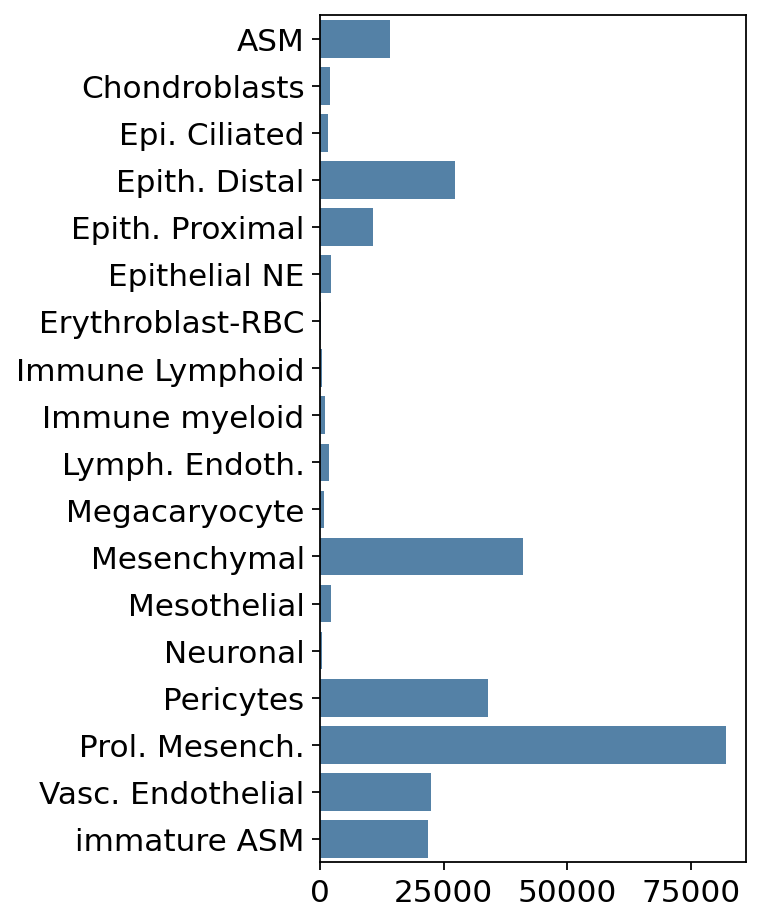

In [9]:
interpreter.data.celltype_frequencies()

# Mean variance plot across cell types 
Distributional characteristics of gene expression measurements of single cells from spatial molecular profiling assays. Shown is the mean variance plot over observed genes. 

* y axis: $\log(\text{var})$ 

* x axis: $\log(\text{mean})$ 

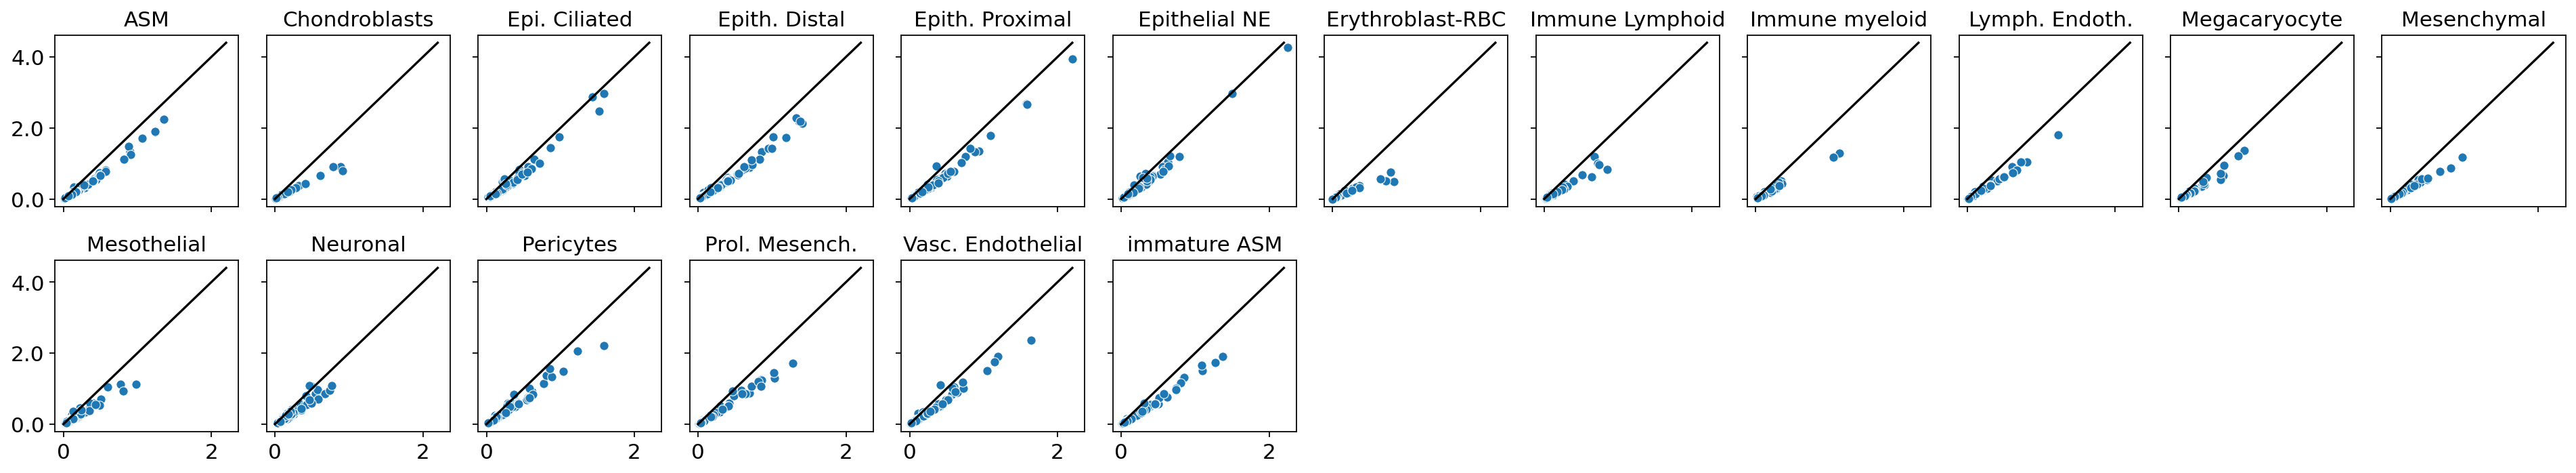

In [10]:
interpreter.data.noise_structure(min_x=0.0, max_x=2.2)

# Calculating sender receiver effects

In [27]:
interpreter.get_sender_receiver_effects()

100%|███████████████████████████████████████████████████████████████████████| 265/265 [13:30<00:00,  3.06s/it]


using ols parameters.
calculating inv fim.


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/diffxpy/stats/stats.py:216: RuntimeWarning: divide by zero encountered in true_divide
  wald_statistic = np.abs(np.divide(theta_mle - theta0, theta_sd))


## Type coupling analysis as heatmap

Colormap refers to count of differentially expressed genes for one specific sender-receiver interaction.

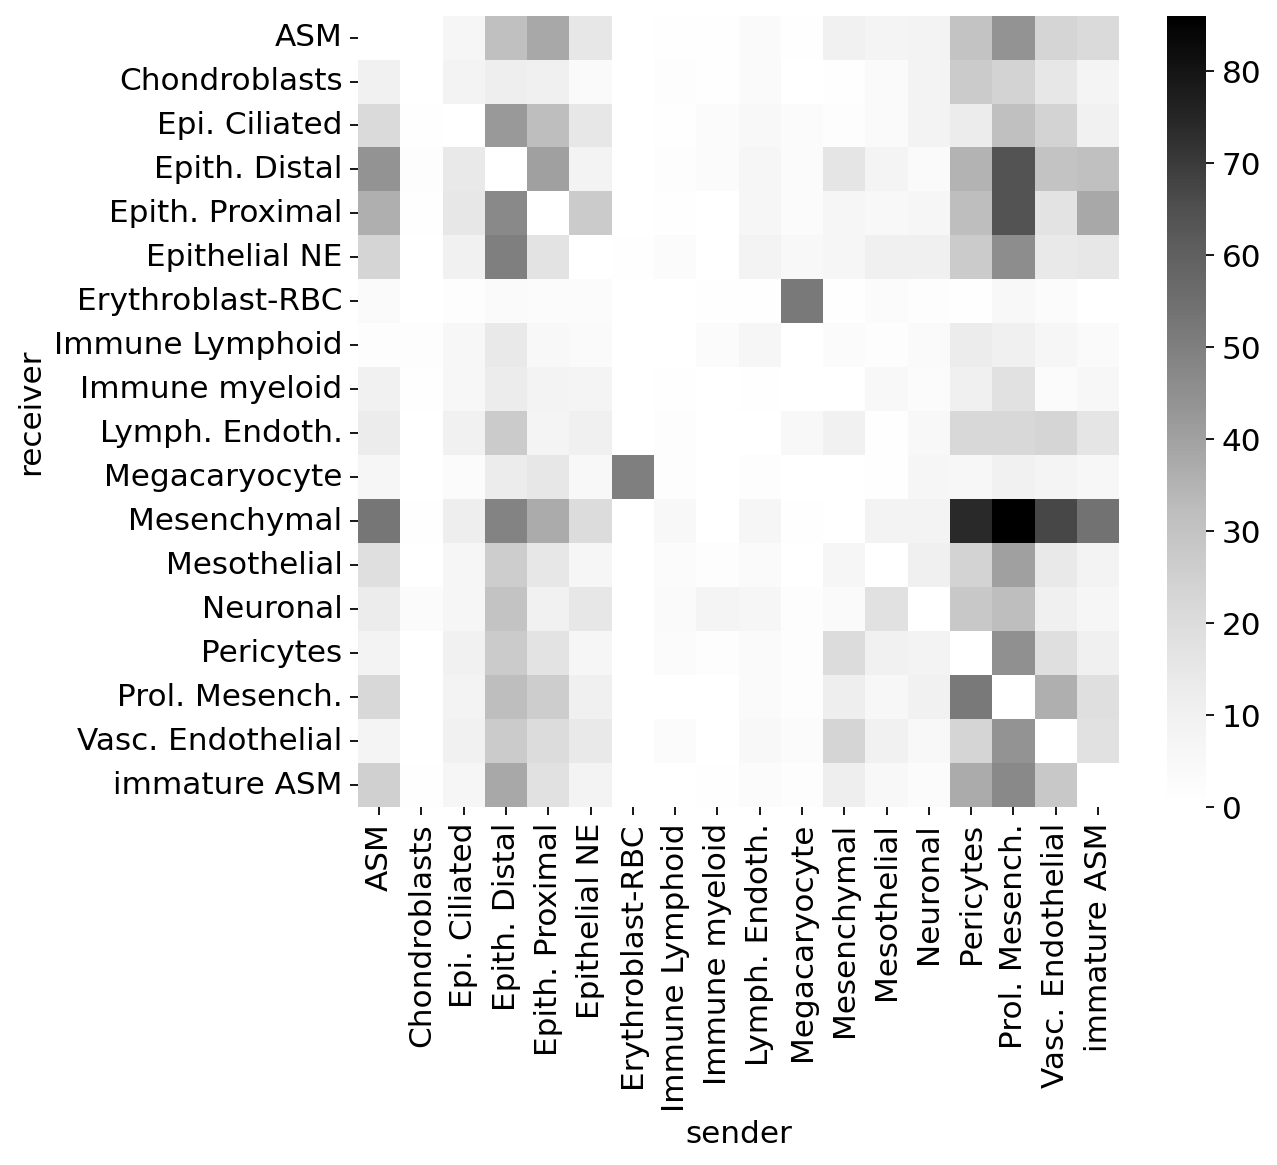

In [12]:
interpreter.type_coupling_analysis(figsize=(8.5, 7.5))

## Type coupling analysis as circular plot
Arrow thickness: strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector

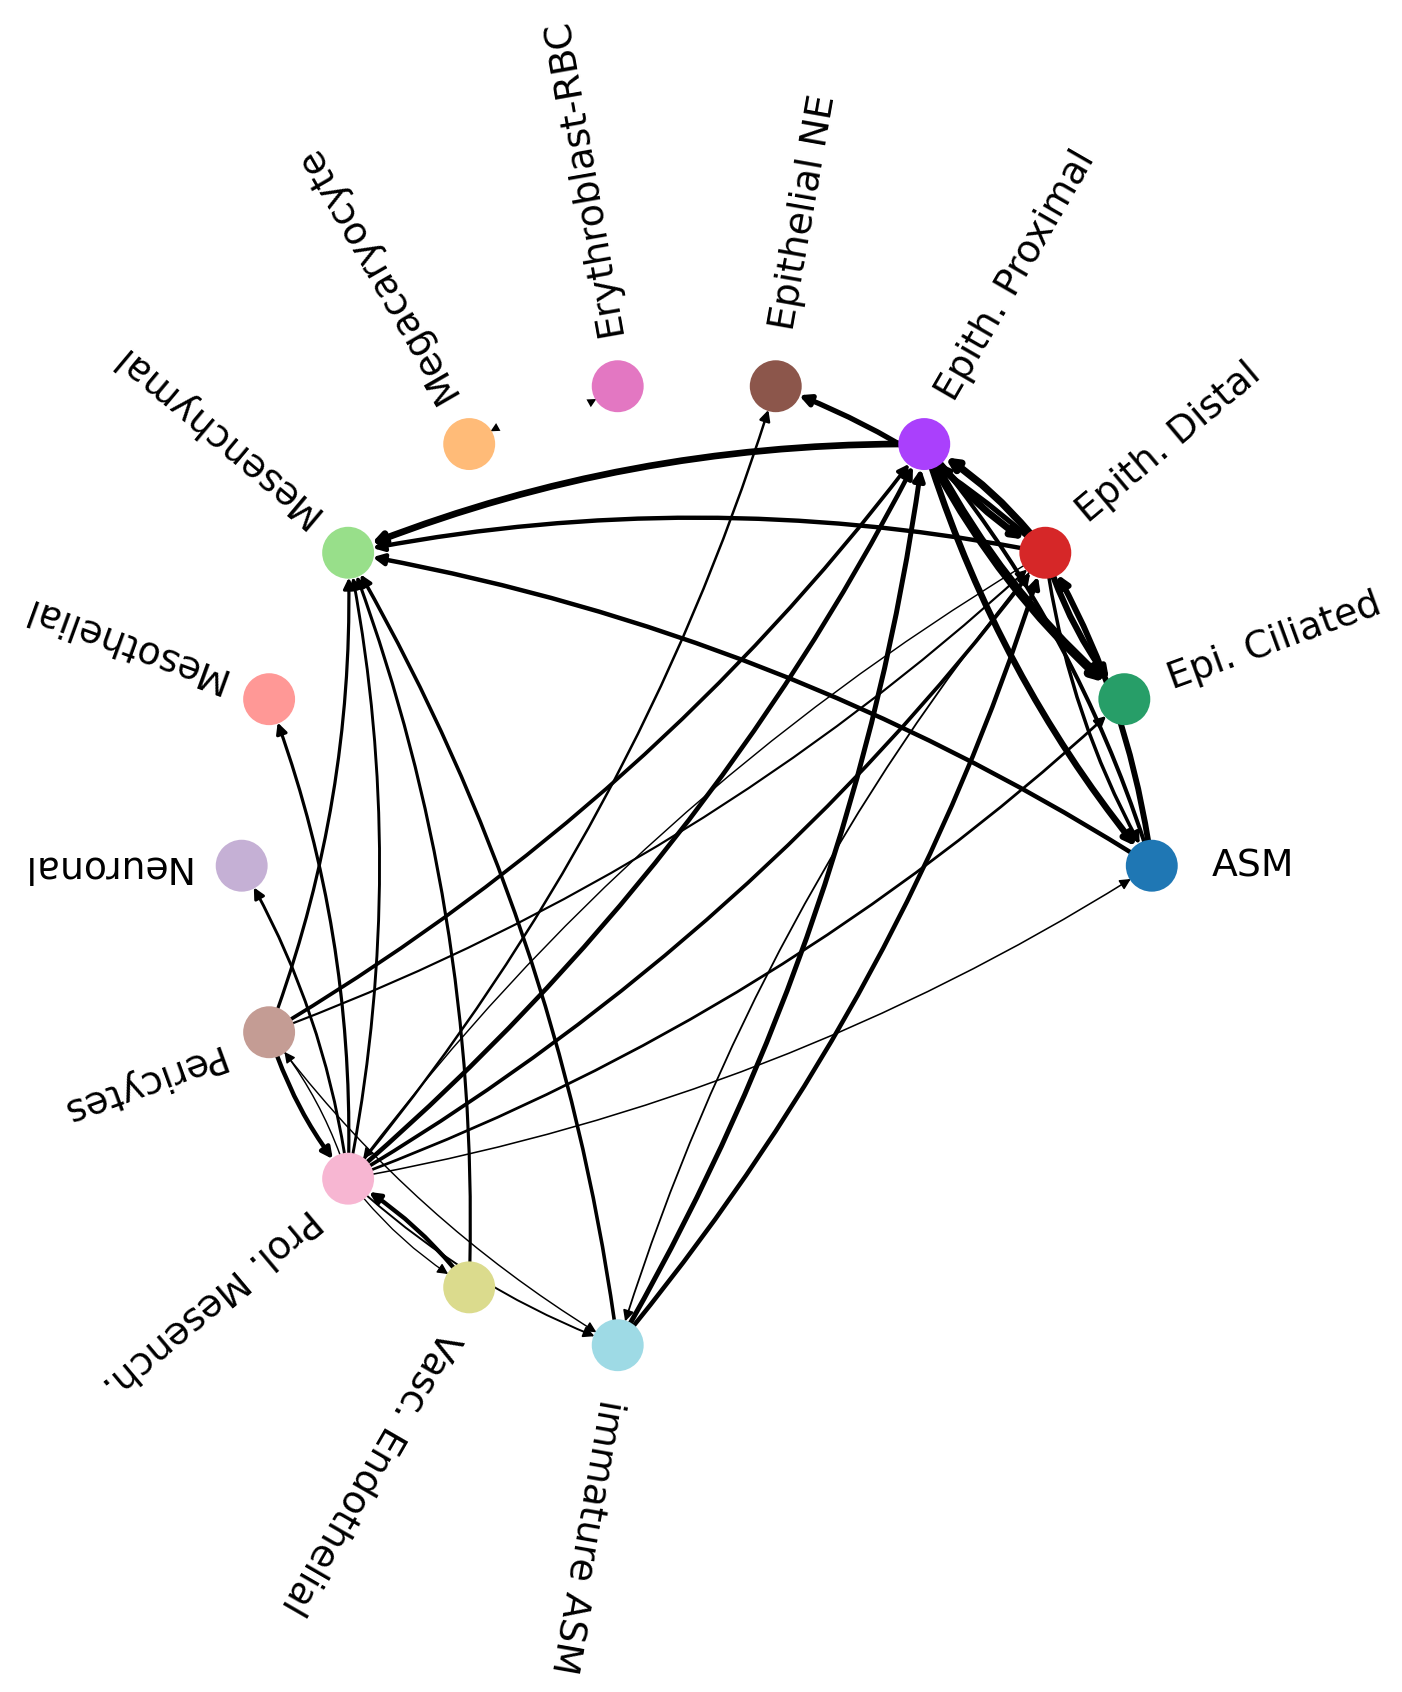

In [18]:
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=1.5,
    interaction_threshold=30,
    figsize=(9,11)
)

Arrow thickness: strength of directional dependencies between cell types as the number of differentially expressed genes of the corresponding interaction.

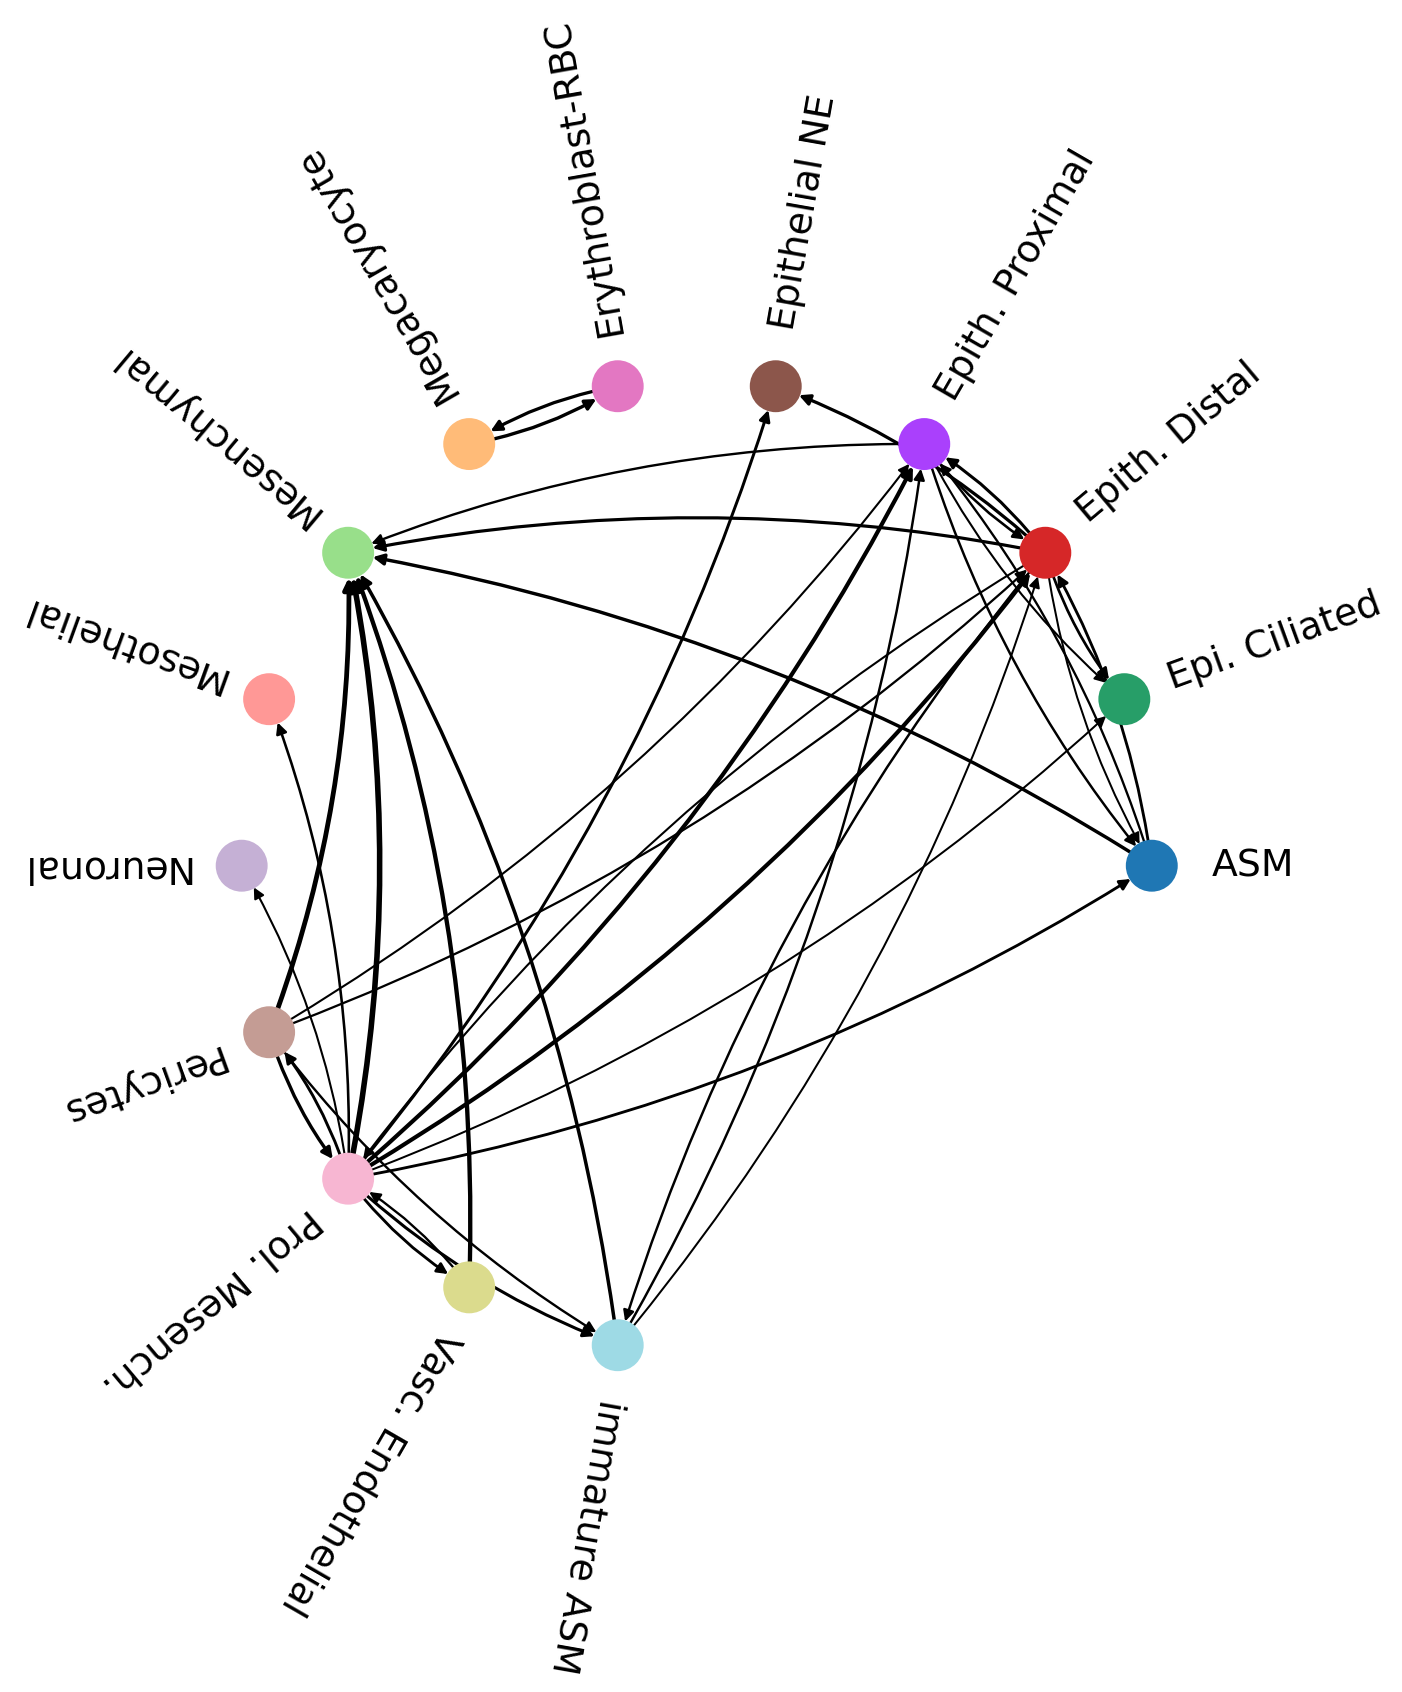

In [14]:
interpreter.type_coupling_analysis_circular(
    edge_attr='de_genes', 
    edge_width_scale=2.5,
    interaction_threshold=30,
    figsize=(9,11)
)

# Sender-receiver effect
Extract effects for one particular sender-receiver effect. This will create a dataframe showing mean expression, pvalue, FDR-corrected pvalue with BH (qvalue) and log fold change

In [15]:
effect_df = interpreter.sender_receiver_values(receiver='Epi. Ciliated', sender='Epith. Proximal')

2.077336


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1135: RuntimeWarning: divide by zero encountered in log10
  y=-np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter],
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1141: RuntimeWarning: divide by zero encountered in log10
  y = -np.nan_to_num(np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter])
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/matplotlib/axes/_base.py:2919: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/ncem/interpretation/interpreter.py:1149: RuntimeWarning: divide by zero encountered in log10
  y = -np.nan_to_num(np.log10(self.qvalues[receiver_idx,sender_idx,:])[qval_filter], neginf=-14.5)
/home/icb/anna.schaar/miniconda3/en

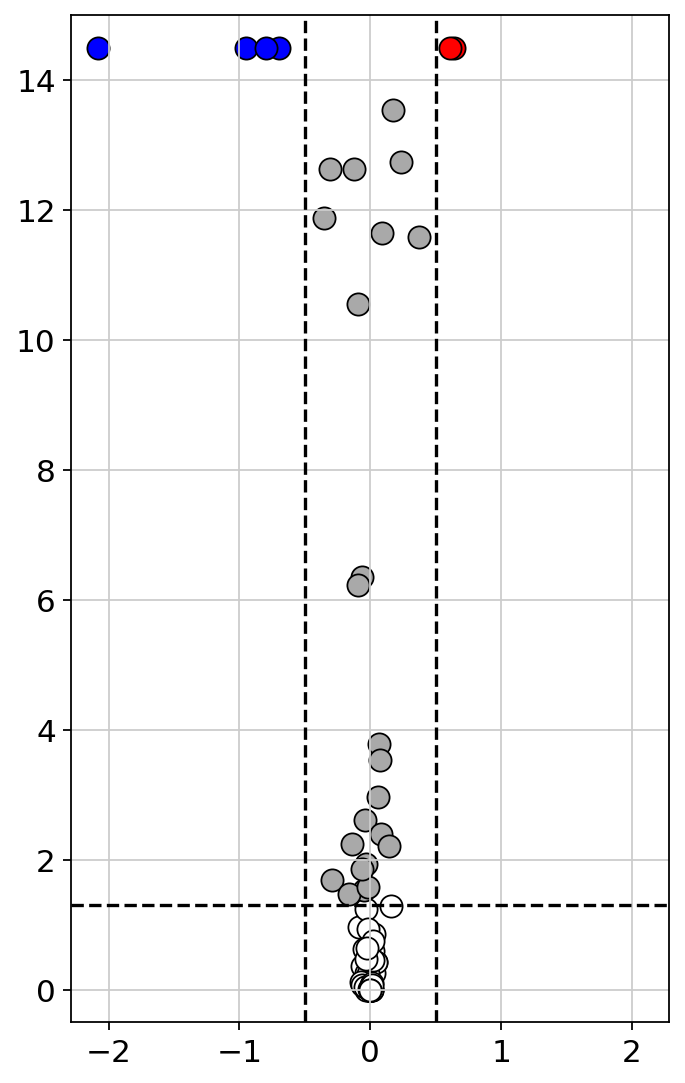

In [29]:
interpreter.sender_receiver_effect_vulcanoplot(
    receiver='Epi. Ciliated', 
    sender='Epith. Proximal',
    fold_change_threshold=0.5
)

In [16]:
effect_df[effect_df['qvalue'] <= 0.05]

,mean expression,pvalue,qvalue,fold change
CPM,0.273177,0.000000e+00,0.000000e+00,-0.700593
CTGF,0.235476,0.000000e+00,0.000000e+00,0.125856
CTNND2,0.148949,2.885591e-04,2.410308e-03,-0.040305
DLL3,0.211990,1.473266e-12,2.754501e-11,-0.097777
DNAH12,0.751545,1.125766e-13,2.242544e-12,0.088493
ETS2,1.373300,0.000000e+00,0.000000e+00,0.638840
FGF20,0.084054,3.168169e-08,4.341861e-07,-0.064668
FGFR1,0.118665,1.633311e-03,1.168658e-02,-0.032092
FGFR2,0.842398,0.000000e+00,0.000000e+00,-2.077336
FZD2,0.116193,1.110223e-14,2.309841e-13,-0.126752


Subsetting to important genes for one sender-receiver interaction. 

In [19]:
gene_subset = effect_df[effect_df['qvalue'] <= 0.05].index

# Sender effect

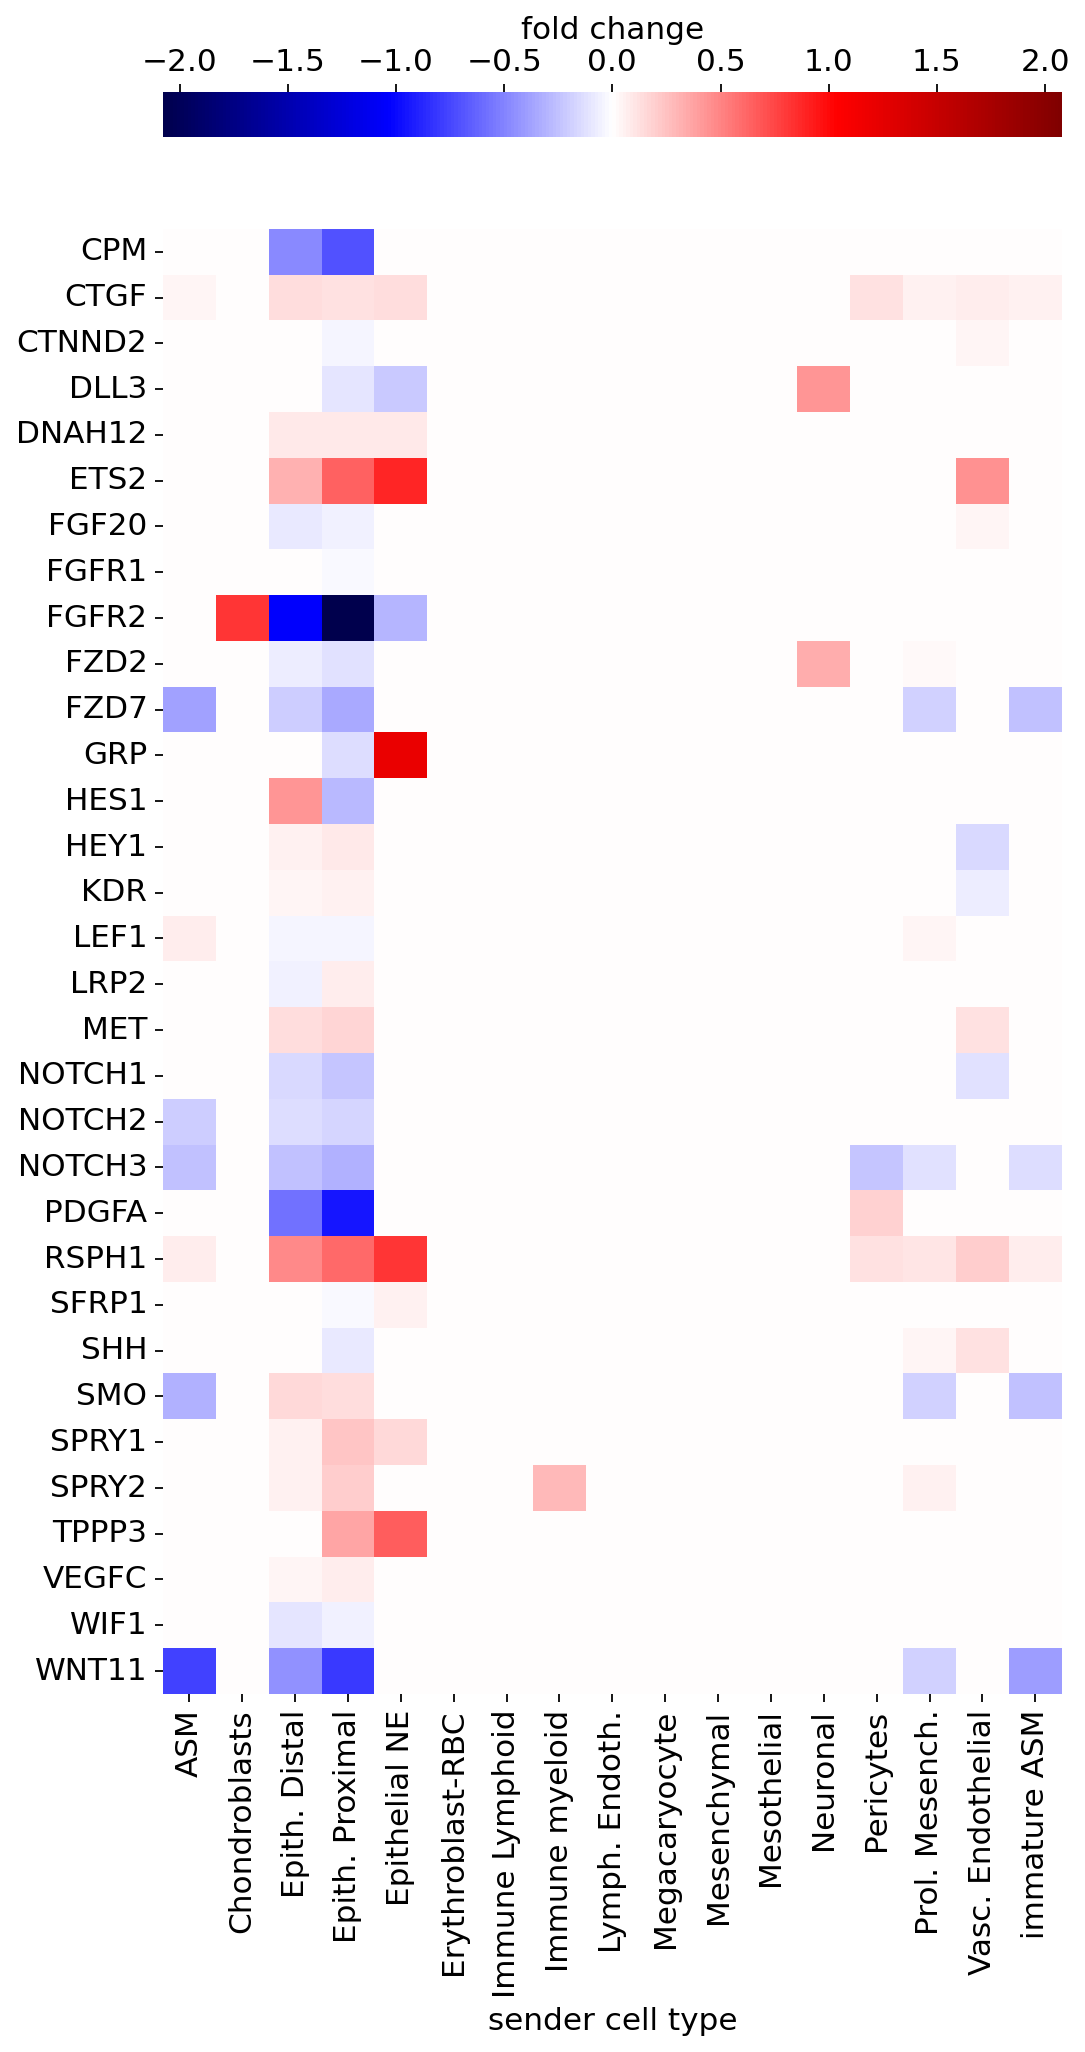

In [20]:
interpreter.sender_effect(receiver='Epi. Ciliated', gene_subset=list(gene_subset), figsize=(7,14))

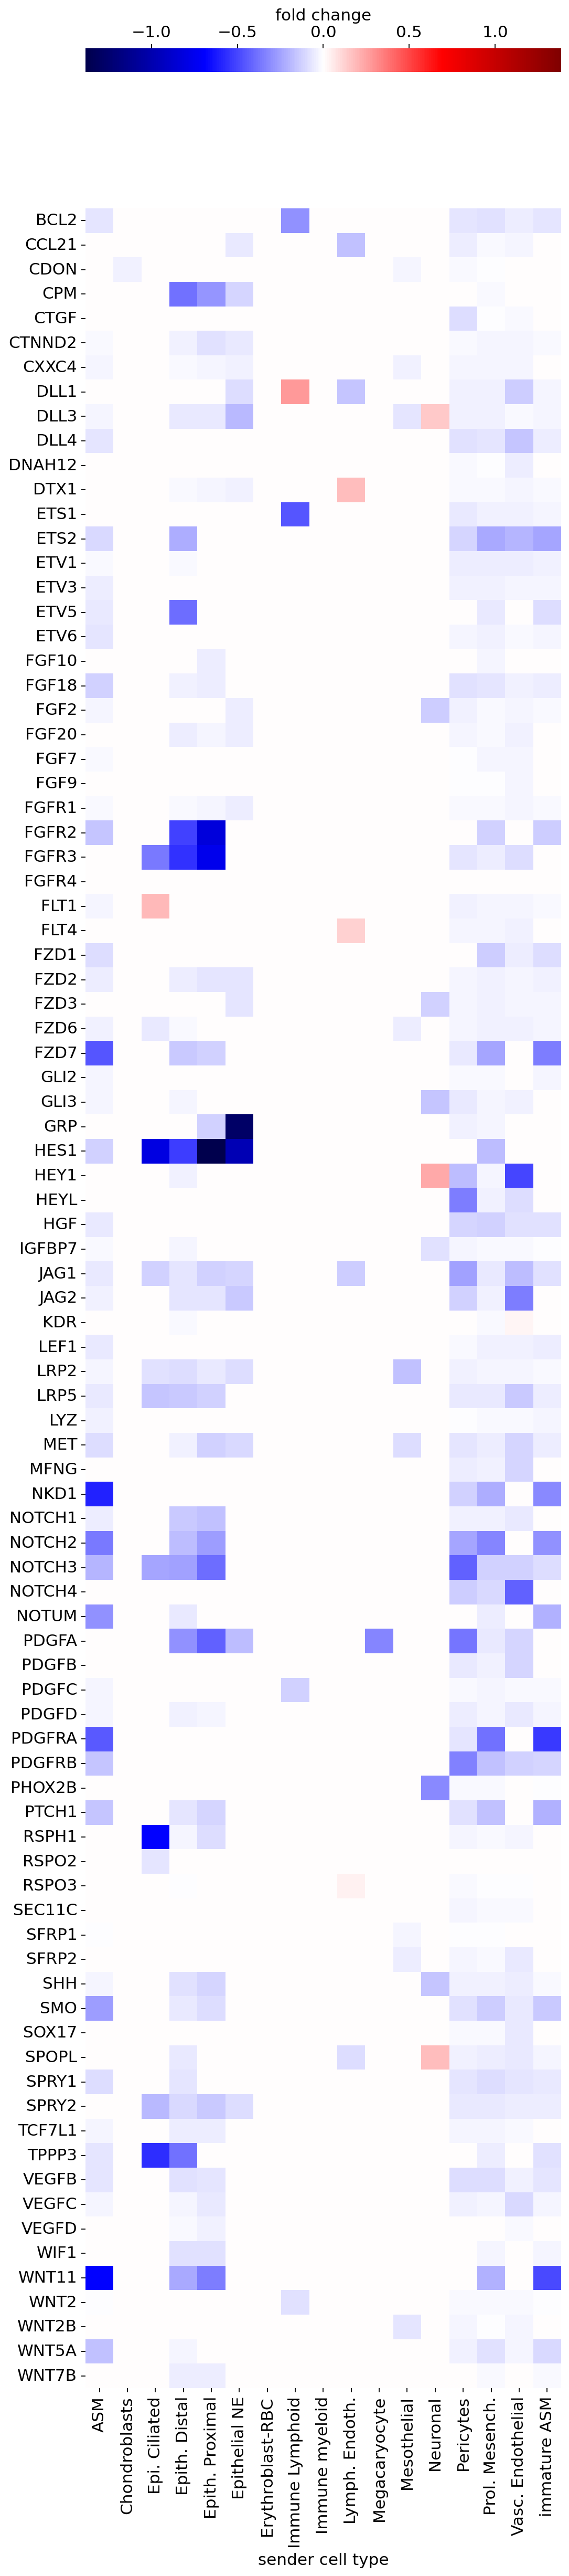

In [23]:
# sender effect for Mesenchymal for all genes
interpreter.sender_effect(receiver='Mesenchymal', gene_subset=list(effect_df.index), figsize=(7,35))

# Receiver effect

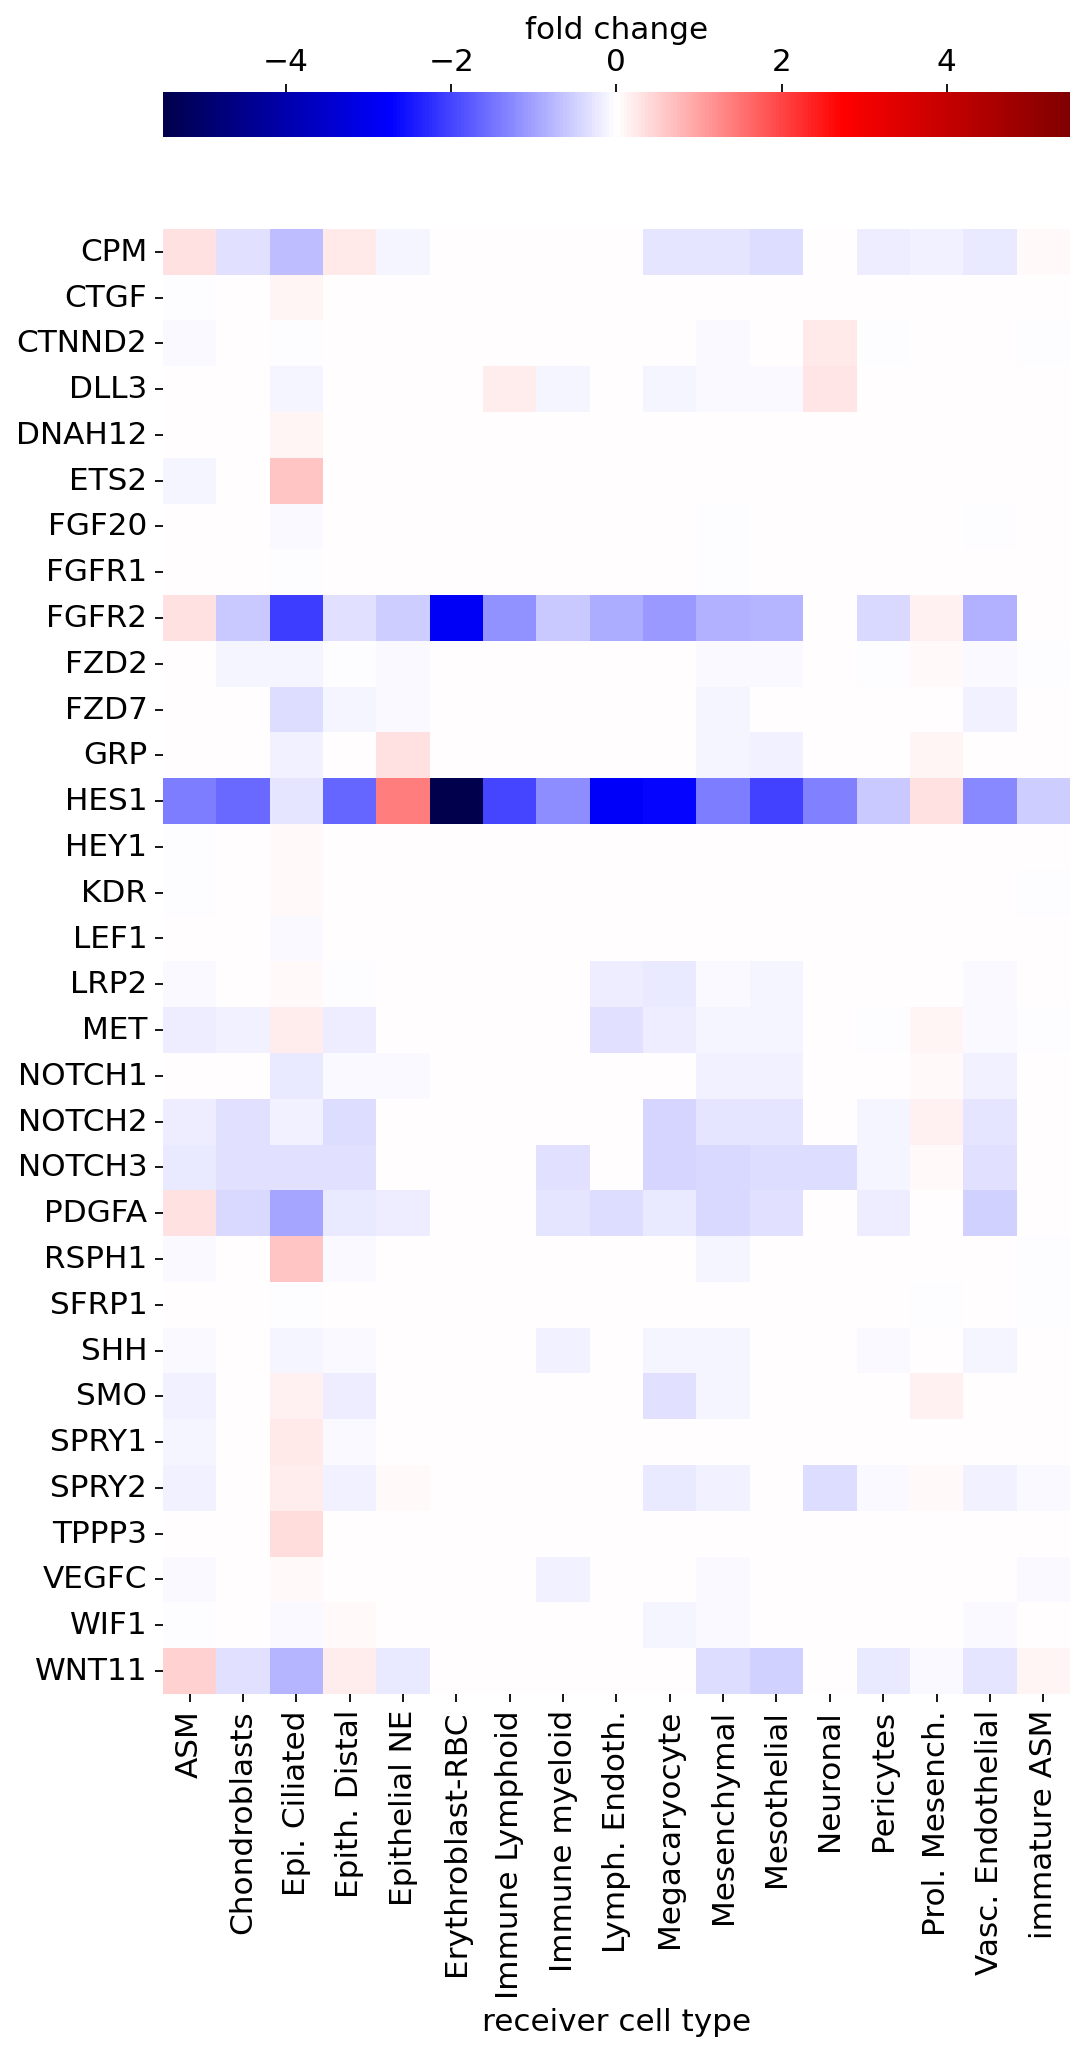

In [24]:
interpreter.receiver_effect(sender='Epith. Proximal', gene_subset=list(gene_subset), figsize=(7,14))